# Melanoma Detection with the ResNet-50 Model

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


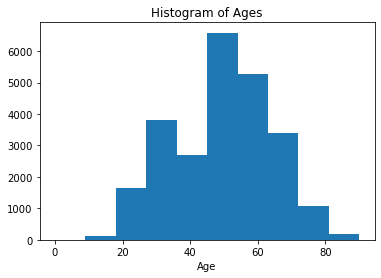

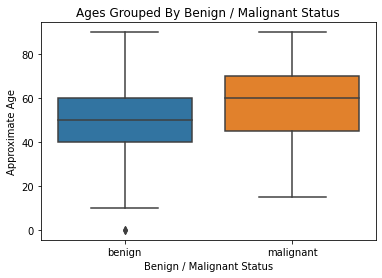

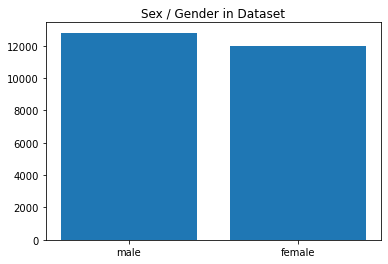

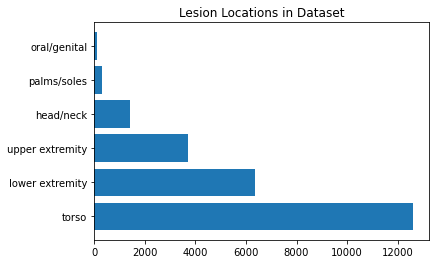

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



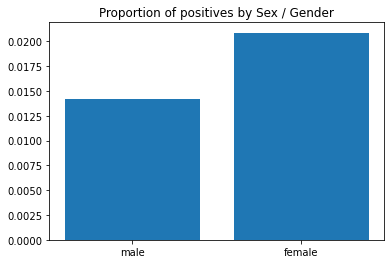



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



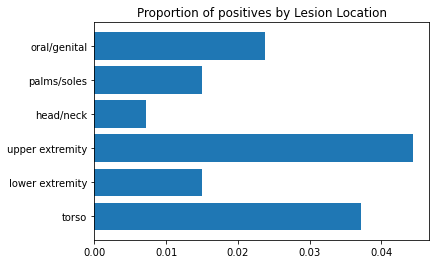

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## ResNet-50 (Feature Extraction)

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 2


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
        
        image_list.append(torch.unsqueeze(_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 16

tr_transf = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Resize(224),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "train.csv"), 
                            num_samples=5*2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [9]:
load_weights = True
create_new_weights = False
PATH = './melanoma_ResNet152.pth'

if load_weights:
    print('Loading the pre-trained ResNet-152 weights.')
    
    # network weights load
    net = torchvision.models.resnet152(weights='IMAGENET1K_V2').to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new ResNet-152 FC Layer weights.')
    
    net = torchvision.models.resnet152(weights='IMAGENET1K_V2').to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)
    
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.001)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    
    

Loading the pre-trained ResNet-152 weights.
CUDA Memory Allocated: 484819456


In [10]:
learn_weights = True

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 1525

        # print every mini-batch
        print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
        print(f'[Epoch {epoch}, Batch {mini_batch % 1525}] Loss: {running_loss / (i+1)}\n')

        # save and outoput every 100 mini-batch
        if i % 100 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
        # eval every 500 mini-batch
        if i % 500 == 0:
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))
            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 1525 == 0:

            uPATH = f'./saved_weights3_tmp/melanoma_ResNet152_{epoch}e_{mini_batch % 1525}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 484819456
CUDA Memory Allocated: 3409839616
[Epoch 10, Batch 6] Loss: 0.16947811841964722

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8971999999999999

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 7] Loss: 0.2616160213947296

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 8] Loss: 0.26937886079152423

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 9] Loss: 0.2816377133131027

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 10] Loss: 0.27578909397125245

CUDA Memory Allocated: 36447

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 100] Loss: 0.32170520244460354

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 101] Loss: 0.3230522524099797

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 102] Loss: 0.3214383559282293

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 103] Loss: 0.3248486571318033

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 104] Loss: 0.32589104478106357

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 105] Loss: 0.32523452796041963

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 106] Loss: 0.3237231662220294

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 107] Loss: 0.324481278000509

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 108] Loss: 0.3270298548549124

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 109] Loss: 0.3263185590935441

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 110] Loss: 0.3265866329982167

CUDA Memory Allocated: 364

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 199] Loss: 0.3119801421140887

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 200] Loss: 0.3132894323422359

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 201] Loss: 0.3125148532646043

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 202] Loss: 0.3122930652296483

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 203] Loss: 0.31162859981108193

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 204] Loss: 0.31156279049327024

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 205] Loss: 0.31152078941464423

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 206] Loss: 0.3113017882873763

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 207] Loss: 0.3109386268228588

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 208] Loss: 0.3101031438910902

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 209] Loss: 0.31012418888071003

CUDA Memory Allocated: 3

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 299] Loss: 0.3026579505681586

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 300] Loss: 0.30226230351096495

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 301] Loss: 0.3026525562729787

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 302] Loss: 0.3022513053684122

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 303] Loss: 0.30162382505884106

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 304] Loss: 0.3016502297044199

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 305] Loss: 0.3010785666108131

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 306] Loss: 0.30114431842617023

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 307] Loss: 0.30102184345785354

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 308] Loss: 0.30244481730775863

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 309] Loss: 0.3024856916775829

CUDA Memory Allocated: 

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 399] Loss: 0.2954814939140366

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 400] Loss: 0.2952161586171464

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 401] Loss: 0.29505918451556656

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 402] Loss: 0.29467756500097003

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 403] Loss: 0.2944415472073471

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 404] Loss: 0.2939528880225387

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 405] Loss: 0.29368375411257147

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 406] Loss: 0.29312885021256685

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 407] Loss: 0.2927497741557769

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 408] Loss: 0.292393638740846

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 409] Loss: 0.29241924583543055

CUDA Memory Allocated: 3

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 499] Loss: 0.2886290755198311

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 500] Loss: 0.28854154458250664

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 501] Loss: 0.2885272649056729

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 502] Loss: 0.28916249640091085

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 503] Loss: 0.2891711554523692

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 504] Loss: 0.28890429101212467

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 505] Loss: 0.2890265461355448

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 506] Loss: 0.2887221436925277

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8891

***********************************

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 594] Loss: 0.2903483682936642

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 595] Loss: 0.2903516519246465

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 596] Loss: 0.29028463322045234

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 597] Loss: 0.29017309080557646

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 598] Loss: 0.29017712566593246

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 599] Loss: 0.29018217517119466

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 600] Loss: 0.2901091205097046

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 601] Loss: 0.2898824430577107

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 602] Loss: 0.2902123076058113

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 603] Loss: 0.29025540409927386

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 604] Loss: 0.2899858810144394

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 605] Loss: 0.28983337997148434

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 693] Loss: 0.2896245605052384

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 694] Loss: 0.2895711168257522

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 695] Loss: 0.28989790938254717

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 696] Loss: 0.2896441686494133

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 697] Loss: 0.289831875322785

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 698] Loss: 0.2898186549630344

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 699] Loss: 0.29009032488856945

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 700] Loss: 0.2899598025911146

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 701] Loss: 0.2900416076333187

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 702] Loss: 0.29038470422306567

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 703] Loss: 0.2904383963598392

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 704] Loss: 0.2902962828803813

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 793] Loss: 0.2900310895561718

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 794] Loss: 0.2901431980940628

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 795] Loss: 0.29023369197038157

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 796] Loss: 0.2901538397302067

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 797] Loss: 0.28997417282538884

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 798] Loss: 0.2898550901801559

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 799] Loss: 0.2900082701793696

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 800] Loss: 0.28984169702297485

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 801] Loss: 0.2899889449247314

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 802] Loss: 0.2900946352401821

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 803] Loss: 0.2902027832106092

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 804] Loss: 0.29005485762829175

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 893] Loss: 0.2914097954577825

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 894] Loss: 0.29129070473501734

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 895] Loss: 0.2911207259119896

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 896] Loss: 0.2909990058151961

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 897] Loss: 0.2908533268061053

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 898] Loss: 0.290842258624841

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 899] Loss: 0.2908127951692015

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 900] Loss: 0.2906444189685017

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 901] Loss: 0.2907269258201787

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 902] Loss: 0.29118230434730563

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 903] Loss: 0.291178134516844

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 904] Loss: 0.2910431816477797

CUDA Memory Allo

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 993] Loss: 0.28811676509165574

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 994] Loss: 0.28814152050367864

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 995] Loss: 0.288103831401377

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 996] Loss: 0.2880861413797625

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 997] Loss: 0.2879609791111321

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 998] Loss: 0.28791507313258696

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 999] Loss: 0.28776611924411305

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1000] Loss: 0.28757431986343923

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1001] Loss: 0.2874681627355426

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1002] Loss: 0.2874151254848109

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1003] Loss: 0.28766794093625103

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1004] Loss: 0.2877253345899038

CUDA M

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1086] Loss: 0.28732319804775175

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1087] Loss: 0.28720434699999425

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1088] Loss: 0.2870703604165207

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1089] Loss: 0.28702313627539083

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1090] Loss: 0.28696825432887274

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1091] Loss: 0.2870274965769678

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1092] Loss: 0.286905191461757

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1093] Loss: 0.2869281003881684

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1094] Loss: 0.28679182248393587

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1095] Loss: 0.2868219379028049

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1096] Loss: 0.2868273165469646

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1097] Loss: 0.28669972947010625


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1185] Loss: 0.28883549312792595

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1186] Loss: 0.28876647897613544

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1187] Loss: 0.2888811618127496

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1188] Loss: 0.28900617685417757

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1189] Loss: 0.2889398300227382

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1190] Loss: 0.28894340175239347

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1191] Loss: 0.28908727917989835

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1192] Loss: 0.28919764183832

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1193] Loss: 0.28908117738260763

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1194] Loss: 0.2889553601309168

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1195] Loss: 0.28892886436411314

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1196] Loss: 0.2887894137943121


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1283] Loss: 0.2918681195399291

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1284] Loss: 0.2918076194048021

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1285] Loss: 0.291687545547029

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1286] Loss: 0.2915485388803631

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1287] Loss: 0.29141402607798206

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1288] Loss: 0.2914069890569451

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1289] Loss: 0.2914292646682244

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1290] Loss: 0.29133038495881086

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1291] Loss: 0.29132479888678153

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1292] Loss: 0.29121916537356174

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1293] Loss: 0.29143590346464643

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1294] Loss: 0.29143492141673505


CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1381] Loss: 0.2924650904809146

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1382] Loss: 0.2924638961157075

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1383] Loss: 0.2923427954402648

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1384] Loss: 0.29228834366997225

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1385] Loss: 0.29227594794786493

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1386] Loss: 0.29217625323583213

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1387] Loss: 0.29212532535346303

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1388] Loss: 0.29199405914187343

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1389] Loss: 0.29189860045565347

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1390] Loss: 0.2917755273221202

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1391] Loss: 0.29174609516154637

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1392] Loss: 0.291636232874895

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1479] Loss: 0.2928873148406862

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1480] Loss: 0.29294814276493203

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1481] Loss: 0.292850644638141

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1482] Loss: 0.2930805654382899

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1483] Loss: 0.29311970214035576

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1484] Loss: 0.29309056858463495

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1485] Loss: 0.2930779658358645

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1486] Loss: 0.2931878083284283

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1487] Loss: 0.2931390109593891

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1488] Loss: 0.2930506258117775

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1489] Loss: 0.29305401865161973

CUDA Memory Allocated: 3644769792
[Epoch 10, Batch 1490] Loss: 0.2930285650973368

C

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 49] Loss: 0.29205346807903965

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 50] Loss: 0.29192554969221923

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 51] Loss: 0.2918718481077122

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 52] Loss: 0.29177148508870115

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 53] Loss: 0.2917523708594732

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 54] Loss: 0.29163393564758944

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 55] Loss: 0.29176107723561545

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 56] Loss: 0.29164092207734055

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 57] Loss: 0.29180018857036427

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 58] Loss: 0.2918573657501635

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 59] Loss: 0.2918882959341233

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 60] Loss: 0.2918806137823606

CUDA Memory Allocated

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 150] Loss: 0.29192736326398966

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 151] Loss: 0.29192061879226794

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 152] Loss: 0.2920629492198879

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 153] Loss: 0.29198106340462765

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 154] Loss: 0.2919085233460048

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 155] Loss: 0.2919228116700898

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 156] Loss: 0.2920953248291852

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 157] Loss: 0.2921249261286974

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 158] Loss: 0.2922118752395581

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 159] Loss: 0.2922937227562824

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 160] Loss: 0.2922364924901298

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 161] Loss: 0.2922006468645949

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 250] Loss: 0.29164169770849624

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 251] Loss: 0.2916115649351624

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 252] Loss: 0.2917545903095677

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 253] Loss: 0.29179704603641904

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 254] Loss: 0.2918566986582459

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 255] Loss: 0.29183192224569726

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 256] Loss: 0.2918949325711609

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 257] Loss: 0.2919640306616071

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 258] Loss: 0.29193680577558395

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 259] Loss: 0.29194600456313113

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 260] Loss: 0.29188874054993136

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 261] Loss: 0.2918684737174314

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 350] Loss: 0.2918460791522169

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 351] Loss: 0.29177511778507303

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 352] Loss: 0.29176732641445774

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 353] Loss: 0.2918364724499366

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 354] Loss: 0.29181198069672704

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 355] Loss: 0.291798055823644

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 356] Loss: 0.29184286580728824

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 357] Loss: 0.291761974721242

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 358] Loss: 0.29184388714476517

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 359] Loss: 0.2917488552094648

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 360] Loss: 0.2916809190778022

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 361] Loss: 0.2917889671430887

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 450] Loss: 0.29053436140648

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 451] Loss: 0.2906735863126455

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 452] Loss: 0.29070102459322245

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 453] Loss: 0.2907236441516719

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 454] Loss: 0.29074072671380446

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 455] Loss: 0.29073050893937485

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 456] Loss: 0.2907204305044251

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 457] Loss: 0.2906354692174319

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 458] Loss: 0.29067196586631666

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 459] Loss: 0.29066279542949114

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 460] Loss: 0.2906557977688734

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 461] Loss: 0.2906117191682074

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 545] Loss: 0.2903143714797699

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 546] Loss: 0.29038299407020196

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 547] Loss: 0.29043671556887674

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 548] Loss: 0.29039284867564186

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 549] Loss: 0.29034444589281266

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 550] Loss: 0.2902576092828587

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 551] Loss: 0.29033818916169873

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 552] Loss: 0.2903808970256029

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 553] Loss: 0.2903277027976438

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 554] Loss: 0.29024234385720904

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 555] Loss: 0.290226429015039

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 556] Loss: 0.29016945768427643

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 644] Loss: 0.28966724720065673

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 645] Loss: 0.2896384749312048

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 646] Loss: 0.2896019137074908

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 647] Loss: 0.28961592734918984

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 648] Loss: 0.2896297500465354

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 649] Loss: 0.2895673437120454

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 650] Loss: 0.28950928732203446

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 651] Loss: 0.2894798644652349

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 652] Loss: 0.2895549372641256

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 653] Loss: 0.2895357664580231

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 654] Loss: 0.2895626835182323

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 655] Loss: 0.28954653734105756

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 744] Loss: 0.2893213882397321

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 745] Loss: 0.28925746847067446

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 746] Loss: 0.2891791113122101

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 747] Loss: 0.2891492932430174

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 748] Loss: 0.28917130798337953

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 749] Loss: 0.28926804029321607

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 750] Loss: 0.289296503942706

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 751] Loss: 0.28927007635119517

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 752] Loss: 0.2892204605593858

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 753] Loss: 0.28917593699402605

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 754] Loss: 0.28917309938681784

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 755] Loss: 0.2892506910483916

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 844] Loss: 0.28894313034647207

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 845] Loss: 0.28898476567001224

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 846] Loss: 0.2889211963884224

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 847] Loss: 0.2888646275119838

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 848] Loss: 0.28887610857349794

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 849] Loss: 0.28884112500299025

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 850] Loss: 0.28884741306807926

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 851] Loss: 0.288811826721016

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 852] Loss: 0.2889688027297063

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 853] Loss: 0.28894397609479006

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 854] Loss: 0.28893624309516297

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 855] Loss: 0.2888606861265082

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 944] Loss: 0.28972251694528506

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 945] Loss: 0.2897033649090579

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 946] Loss: 0.2897591409118603

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 947] Loss: 0.28973706204928895

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 948] Loss: 0.28976860483036626

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 949] Loss: 0.2897851730030333

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 950] Loss: 0.28973579814559536

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 951] Loss: 0.28967210989353487

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 952] Loss: 0.2896567868207458

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 953] Loss: 0.2896268010995092

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 954] Loss: 0.28957259147251047

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 955] Loss: 0.28952080678458164

CUDA Memo

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1037] Loss: 0.2894865097386976

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1038] Loss: 0.2894578573466559

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1039] Loss: 0.28951461650445715

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1040] Loss: 0.289460292912554

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1041] Loss: 0.2894474191388224

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1042] Loss: 0.28939406093352477

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1043] Loss: 0.2893742300945011

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1044] Loss: 0.2894047138494746

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1045] Loss: 0.28934804894189853

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1046] Loss: 0.28928990721330916

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1047] Loss: 0.2892353992007983

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1048] Loss: 0.28925813594107685



CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1136] Loss: 0.2898361300179982

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1137] Loss: 0.2898905621291239

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1138] Loss: 0.28990767241656734

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1139] Loss: 0.2898867741092653

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1140] Loss: 0.2898465068688742

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1141] Loss: 0.28988733093335817

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1142] Loss: 0.28995091638546705

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1143] Loss: 0.2899700349243655

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1144] Loss: 0.2899383743497747

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1145] Loss: 0.2899380427839385

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1146] Loss: 0.2899623234230195

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1147] Loss: 0.29012108855103125



CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1234] Loss: 0.2899149365685258

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1235] Loss: 0.2900027681446335

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1236] Loss: 0.2900910355280463

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1237] Loss: 0.2900455553256216

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1238] Loss: 0.28997641597604995

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1239] Loss: 0.2899792495846273

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1240] Loss: 0.2899352525347385

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1241] Loss: 0.2898939272948082

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1242] Loss: 0.28989251289222656

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1243] Loss: 0.2898317976351497

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1244] Loss: 0.28975950999053357

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1245] Loss: 0.28977624033771415



CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1332] Loss: 0.2890790829965309

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1333] Loss: 0.2890990874013523

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1334] Loss: 0.28919903917294243

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1335] Loss: 0.2891425248411616

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1336] Loss: 0.289170171585487

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1337] Loss: 0.28919402189425

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1338] Loss: 0.28913660271339603

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1339] Loss: 0.2890798218519632

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1340] Loss: 0.2890442109660252

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1341] Loss: 0.28898317036627474

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1342] Loss: 0.28893939683449427

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1343] Loss: 0.2889381512853802

CUD

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1430] Loss: 0.289448874067452

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1431] Loss: 0.28945676926353026

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1432] Loss: 0.2894271581224229

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1433] Loss: 0.28943165820350575

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1434] Loss: 0.2894723063830435

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1435] Loss: 0.2894506854403846

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1436] Loss: 0.2893805554255097

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1437] Loss: 0.2893345057661968

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1438] Loss: 0.2892975342221321

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1439] Loss: 0.28928246865525525

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1440] Loss: 0.28928142360134707

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1441] Loss: 0.28921794770578

CUD

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1523] Loss: 0.2897569526377435

CUDA Memory Allocated: 3644769792
[Epoch 11, Batch 1524] Loss: 0.28971341316332444

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 0] Loss: 0.2897628881795751

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1] Loss: 0.2897595399470898

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 2] Loss: 0.28975971788290217

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 3] Loss: 0.28972950968720274

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 4] Loss: 0.2897419182137119

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 5] Loss: 0.2897095125950262

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 6] Loss: 0.2896642154128444

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 7] Loss: 0.28974983875235716

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 8] Loss: 0.2897157233783135

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 9] Loss: 0.2897186573111765

CUDA Memory Allocated: 3644769

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 99] Loss: 0.2897126991384717

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 100] Loss: 0.2896760269253261

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 101] Loss: 0.289697823340271

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 102] Loss: 0.28973157855752807

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 103] Loss: 0.2897027611124224

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 104] Loss: 0.2897056605443287

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 105] Loss: 0.28969609840876526

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 106] Loss: 0.2896678413236966

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 107] Loss: 0.28967604163424276

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 108] Loss: 0.28963760629797264

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 109] Loss: 0.289595631074654

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 110] Loss: 0.28963857036550333

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 199] Loss: 0.28951459324605183

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 200] Loss: 0.28951992959082584

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 201] Loss: 0.28954179442555944

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 202] Loss: 0.2895125810138383

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 203] Loss: 0.28946996722347446

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 204] Loss: 0.28947956846650286

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 205] Loss: 0.2894137909813569

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 206] Loss: 0.28942347115913525

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 207] Loss: 0.28938523405386185

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 208] Loss: 0.2894065715716118

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 209] Loss: 0.2894233355782903

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 210] Loss: 0.2894665258763481

CUDA Memo

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 299] Loss: 0.29035207083444314

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 300] Loss: 0.290314901192493

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 301] Loss: 0.290336987825341

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 302] Loss: 0.2903243786406884

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 303] Loss: 0.2903286371538093

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 304] Loss: 0.29033004526225764

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 305] Loss: 0.2902925331879463

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 306] Loss: 0.29031518009755014

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 307] Loss: 0.29029945046407546

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 308] Loss: 0.2902765655809557

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 309] Loss: 0.29026756535706844

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 310] Loss: 0.29023853015548784

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 399] Loss: 0.2912939721069425

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 400] Loss: 0.2912752743221073

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 401] Loss: 0.2913409148073186

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 402] Loss: 0.2912968150268422

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 403] Loss: 0.2912902248053101

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 404] Loss: 0.2912623039950371

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 405] Loss: 0.29127829763876356

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 406] Loss: 0.2912462207123581

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 407] Loss: 0.291262444437871

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 408] Loss: 0.29126405552495677

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 409] Loss: 0.2912278342237087

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 410] Loss: 0.29123238630582043

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 494] Loss: 0.2915884120751401

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 495] Loss: 0.2915370577862118

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 496] Loss: 0.29149743701354724

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 497] Loss: 0.2914677979061743

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 498] Loss: 0.2914491478020429

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 499] Loss: 0.2914392641560505

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 500] Loss: 0.2914547825492235

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 501] Loss: 0.2914256360781055

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 502] Loss: 0.2914396571617732

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 503] Loss: 0.2913882429905765

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 504] Loss: 0.2913933025080491

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 505] Loss: 0.291376942999556

CUDA Memory Allo

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 593] Loss: 0.2910371320501355

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 594] Loss: 0.290998689952125

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 595] Loss: 0.29101048427234805

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 596] Loss: 0.291015571281539

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 597] Loss: 0.29100557436009705

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 598] Loss: 0.29099064666267577

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 599] Loss: 0.29109914695821565

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 600] Loss: 0.2910743000872423

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 601] Loss: 0.2910352983060883

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 602] Loss: 0.29104702188657644

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 603] Loss: 0.2910522648527516

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 604] Loss: 0.2910884779786845

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 693] Loss: 0.2909855640011477

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 694] Loss: 0.2909520350468369

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 695] Loss: 0.2909393501522787

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 696] Loss: 0.2909126773076289

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 697] Loss: 0.29094360138522085

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 698] Loss: 0.2909209400090963

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 699] Loss: 0.2909504004732236

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 700] Loss: 0.2909098950392493

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 701] Loss: 0.29086877747443324

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 702] Loss: 0.29084085988356556

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 703] Loss: 0.2908231256581374

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 704] Loss: 0.29092129006600276

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 793] Loss: 0.29126400102867533

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 794] Loss: 0.2912777649807834

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 795] Loss: 0.29126978232816325

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 796] Loss: 0.2912282272562311

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 797] Loss: 0.29126738114907896

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 798] Loss: 0.2913128965808844

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 799] Loss: 0.2913245471896028

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 800] Loss: 0.29133398588577236

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 801] Loss: 0.29128806538166974

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 802] Loss: 0.291308725839091

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 803] Loss: 0.29130739975321784

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 804] Loss: 0.2912514278726644

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 893] Loss: 0.2912493583681455

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 894] Loss: 0.29125322804883913

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 895] Loss: 0.29126888409654045

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 896] Loss: 0.29135402365271224

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 897] Loss: 0.2913466327162653

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 898] Loss: 0.2914094786052697

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 899] Loss: 0.2913672632243084

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 900] Loss: 0.2913763919890078

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 901] Loss: 0.291348620761116

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 902] Loss: 0.2913521216657982

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 903] Loss: 0.2913271580957699

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 904] Loss: 0.2913097966519918

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 988] Loss: 0.2913871017512615

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 989] Loss: 0.2915061827837667

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 990] Loss: 0.2915027094550218

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 991] Loss: 0.29152102742853647

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 992] Loss: 0.2915696840385399

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 993] Loss: 0.2915920269227651

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 994] Loss: 0.29158625131651417

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 995] Loss: 0.2915669534198645

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 996] Loss: 0.29157137018516643

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 997] Loss: 0.29157710390488945

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 998] Loss: 0.29156107908552925

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 999] Loss: 0.2916325578598709

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1087] Loss: 0.29184007665209133

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1088] Loss: 0.29197745596976016

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1089] Loss: 0.2919430987676042

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1090] Loss: 0.2919215129465405

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1091] Loss: 0.29192213894262536

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1092] Loss: 0.29195988946183454

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1093] Loss: 0.29195768670248723

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1094] Loss: 0.2919398750889327

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1095] Loss: 0.2919652824204613

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1096] Loss: 0.29192580163579607

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1097] Loss: 0.29188866538091424

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1098] Loss: 0.291855502885348

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1185] Loss: 0.29191406490039035

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1186] Loss: 0.2918822238016174

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1187] Loss: 0.29188435826457626

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1188] Loss: 0.2918758094768391

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1189] Loss: 0.29185198978413146

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1190] Loss: 0.29188460241453423

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1191] Loss: 0.2918985627056913

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1192] Loss: 0.29188304154805933

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1193] Loss: 0.29187276878549334

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1194] Loss: 0.2918439599689545

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1195] Loss: 0.29181241750154857

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1196] Loss: 0.291820334013664

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1283] Loss: 0.29201366451642924

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1284] Loss: 0.29198128327324585

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1285] Loss: 0.2919995417513005

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1286] Loss: 0.2920094615016653

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1287] Loss: 0.29201846629112876

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1288] Loss: 0.2920112187915907

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1289] Loss: 0.29196596721012746

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1290] Loss: 0.2919213618219518

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1291] Loss: 0.2919994623304046

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1292] Loss: 0.2919872843806222

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1293] Loss: 0.29194815530033363

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1294] Loss: 0.29194337666364384

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1381] Loss: 0.29158464265701944

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1382] Loss: 0.29154815180309207

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1383] Loss: 0.29153743293052226

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1384] Loss: 0.2915216634110151

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1385] Loss: 0.2915263630500227

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1386] Loss: 0.2915342404641408

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1387] Loss: 0.2915778493656632

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1388] Loss: 0.2915736450793752

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1389] Loss: 0.2915720015421449

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1390] Loss: 0.29156383084807347

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1391] Loss: 0.2915241078492943

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1392] Loss: 0.29153247524354275


CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1474] Loss: 0.29191026832511874

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1475] Loss: 0.29190569010653855

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1476] Loss: 0.291913298244393

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1477] Loss: 0.2919469064794405

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1478] Loss: 0.2919234220476349

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1479] Loss: 0.29191077269027443

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1480] Loss: 0.2919752759795163

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1481] Loss: 0.29203964647694175

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1482] Loss: 0.29204896650344353

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1483] Loss: 0.29211768986124137

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1484] Loss: 0.29215883406207743

CUDA Memory Allocated: 3644769792
[Epoch 12, Batch 1485] Loss: 0.2922077921085537

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 48] Loss: 0.29236936964007515

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 49] Loss: 0.2923284670163424

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 50] Loss: 0.29232638436510705

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 51] Loss: 0.2923317764456642

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 52] Loss: 0.29240759242727404

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 53] Loss: 0.2924119199805643

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 54] Loss: 0.2923949570330601

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 55] Loss: 0.29237303927943514

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 56] Loss: 0.29242437364919277

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 57] Loss: 0.29246874454889954

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 58] Loss: 0.2924705666208973

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 59] Loss: 0.29249267196888334

CUDA Memory Allocated

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 148] Loss: 0.2921940847937588

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 149] Loss: 0.2921982721207909

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 150] Loss: 0.29226902390088316

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 151] Loss: 0.2923212592280712

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 152] Loss: 0.2922939188046281

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 153] Loss: 0.2923312296374304

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 154] Loss: 0.2923199595247887

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 155] Loss: 0.2923212936646724

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 156] Loss: 0.29230387112061906

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 157] Loss: 0.29230122364819466

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 158] Loss: 0.2922666788892269

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 159] Loss: 0.29226361494452285

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 248] Loss: 0.29237392047577104

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 249] Loss: 0.2923707004468776

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 250] Loss: 0.29233174029258524

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 251] Loss: 0.292328660233996

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 252] Loss: 0.2923362396645106

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 253] Loss: 0.29236833395124745

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 254] Loss: 0.2923368435726805

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 255] Loss: 0.29237272457600877

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 256] Loss: 0.29244493343741923

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 257] Loss: 0.2924646370842982

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 258] Loss: 0.2924291687448877

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 259] Loss: 0.29241553553298877

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 348] Loss: 0.29247043833997055

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 349] Loss: 0.29247331511873764

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 350] Loss: 0.29251390503401437

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 351] Loss: 0.29250264269983206

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 352] Loss: 0.2924838161178475

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 353] Loss: 0.2924515550444215

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 354] Loss: 0.2924475095436812

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 355] Loss: 0.2924261942626861

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 356] Loss: 0.29242563396057025

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 357] Loss: 0.2924389978672274

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 358] Loss: 0.2924278040443753

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 359] Loss: 0.29240642390203514

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 443] Loss: 0.2926562176896573

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 444] Loss: 0.292649776660319

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 445] Loss: 0.292710263768614

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 446] Loss: 0.2927317117820635

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 447] Loss: 0.2927270123454021

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 448] Loss: 0.29278407515360333

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 449] Loss: 0.2927484459734148

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 450] Loss: 0.29274616645300294

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 451] Loss: 0.2927538351565926

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 452] Loss: 0.2927349727246235

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 453] Loss: 0.2927494223848677

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 454] Loss: 0.2927467425333063

CUDA Memory Allo

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 542] Loss: 0.29331793662755284

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 543] Loss: 0.29331211214304065

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 544] Loss: 0.29330937637655025

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 545] Loss: 0.2933725967012775

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 546] Loss: 0.2933570651309834

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 547] Loss: 0.29336662319824985

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 548] Loss: 0.2933570940168331

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 549] Loss: 0.2933657247108113

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 550] Loss: 0.29333124899276297

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 551] Loss: 0.29331721708373476

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 552] Loss: 0.29330562723219417

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 553] Loss: 0.2932727771949168

CUDA Memo

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 642] Loss: 0.2931605977644531

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 643] Loss: 0.29312601342651495

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 644] Loss: 0.2931088307335841

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 645] Loss: 0.2931098535485487

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 646] Loss: 0.2930890390509454

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 647] Loss: 0.29305730463188223

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 648] Loss: 0.29306370468689547

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 649] Loss: 0.2931070768583618

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 650] Loss: 0.2930884648771007

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 651] Loss: 0.293078614927199

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 652] Loss: 0.29308785370161183

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 653] Loss: 0.2931630069052217

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 742] Loss: 0.2929463343279638

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 743] Loss: 0.2929908435166993

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 744] Loss: 0.2930013787703807

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 745] Loss: 0.2930129196827746

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 746] Loss: 0.29298585669282595

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 747] Loss: 0.29298270155337824

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 748] Loss: 0.29300825943698916

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 749] Loss: 0.29303976010113064

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 750] Loss: 0.2930132126841778

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 751] Loss: 0.2929980724775529

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 752] Loss: 0.2930020311919427

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 753] Loss: 0.2929698872262209

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 842] Loss: 0.2925049954996405

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 843] Loss: 0.2925149292364901

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 844] Loss: 0.2925353975017704

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 845] Loss: 0.29253709791769944

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 846] Loss: 0.29253456748724865

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 847] Loss: 0.2925375639258968

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 848] Loss: 0.2925555795629159

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 849] Loss: 0.29253926266051455

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 850] Loss: 0.292537114793964

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 851] Loss: 0.29253572492202784

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 852] Loss: 0.29255910024832904

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 853] Loss: 0.2925384613325867

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 937] Loss: 0.2924749426271774

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 938] Loss: 0.29249554135841394

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 939] Loss: 0.2925037877743377

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 940] Loss: 0.29250186802633443

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 941] Loss: 0.29247423772034464

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 942] Loss: 0.2924806907454016

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 943] Loss: 0.292461854669742

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 944] Loss: 0.2924488884439752

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 945] Loss: 0.29243254154677406

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 946] Loss: 0.2924109159349488

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 947] Loss: 0.2923861203530527

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 948] Loss: 0.29238654607478237

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1036] Loss: 0.2922632485745083

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1037] Loss: 0.2922576059307754

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1038] Loss: 0.29223281011973823

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1039] Loss: 0.2922036938992259

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1040] Loss: 0.29220180445335764

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1041] Loss: 0.29218086394752074

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1042] Loss: 0.29219290834512357

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1043] Loss: 0.29217499217926746

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1044] Loss: 0.29217187422193325

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1045] Loss: 0.2921439703404638

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1046] Loss: 0.2921560892193151

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1047] Loss: 0.2921377595886124

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1134] Loss: 0.2919961753736288

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1135] Loss: 0.2919764484782474

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1136] Loss: 0.29196232278650786

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1137] Loss: 0.29196181516576736

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1138] Loss: 0.29193660730173643

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1139] Loss: 0.2919546287590995

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1140] Loss: 0.2919753101682078

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1141] Loss: 0.29200559076964805

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1142] Loss: 0.2919977611316895

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1143] Loss: 0.2919880543592075

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1144] Loss: 0.29197069928754155

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1145] Loss: 0.2919934607631578


CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1232] Loss: 0.29218765466978985

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1233] Loss: 0.2922036007416468

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1234] Loss: 0.2922878201439884

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1235] Loss: 0.2922887304225017

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1236] Loss: 0.2922981724135329

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1237] Loss: 0.2923091868471418

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1238] Loss: 0.2923397173060838

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1239] Loss: 0.29234778561835695

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1240] Loss: 0.2923677526516984

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1241] Loss: 0.29238723546799933

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1242] Loss: 0.2923652508192877

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1243] Loss: 0.29235278675324655



CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1332] Loss: 0.2922817544045286

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1333] Loss: 0.2922893612705993

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1334] Loss: 0.2923594200819589

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1335] Loss: 0.2923530404505641

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1336] Loss: 0.29234045238195944

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1337] Loss: 0.2923810205330739

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1338] Loss: 0.29236012709200304

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1339] Loss: 0.29233685041905294

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1340] Loss: 0.29233801691539196

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1341] Loss: 0.2923798945171037

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1342] Loss: 0.29238355310863146

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1343] Loss: 0.2923922861515014


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8891

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1432] Loss: 0.2927189579085186

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1433] Loss: 0.29270636004600725

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1434] Loss: 0.2926985685323315

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1435] Loss: 0.2927186014985264

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1436] Loss: 0.2927011325744502

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1437] Loss: 0.29268757325575556

CUDA Memory Allocated: 3644769792
[Epoch 13, Batch 1438] Loss

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1] Loss: 0.2928047238194

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 2] Loss: 0.29279319597757975

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 3] Loss: 0.29276498134051554

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 4] Loss: 0.29277003890232955

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 5] Loss: 0.29275689877813954

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 6] Loss: 0.2927314670855072

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 7] Loss: 0.2927267864891073

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 8] Loss: 0.2927081173408838

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 9] Loss: 0.2927001466203193

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 10] Loss: 0.292710689690199

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 11] Loss: 0.2927171390526829

CUDA Memory Allocated: 3644769792
[Epoch 14, Bat

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 101] Loss: 0.29271682596773274

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 102] Loss: 0.2926990921006907

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 103] Loss: 0.29267732724162715

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 104] Loss: 0.292663323152573

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 105] Loss: 0.292653938665265

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 106] Loss: 0.29263826030465867

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 107] Loss: 0.29262999293473374

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 108] Loss: 0.29264743175095137

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 109] Loss: 0.29264048823329

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 110] Loss: 0.29265080915762476

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 111] Loss: 0.2926616361181639

CUDA Memory Allocated: 364

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 201] Loss: 0.292712548192652

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 202] Loss: 0.2927533531931538

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 203] Loss: 0.2927525308587677

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 204] Loss: 0.29273521087698223

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 205] Loss: 0.29271891134953687

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 206] Loss: 0.292711475645005

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 207] Loss: 0.2927048904085322

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 208] Loss: 0.29268920147714966

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 209] Loss: 0.29266578117314596

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 210] Loss: 0.2926820714295525

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 211] Loss: 0.29266446714826777

CUDA Memory Allocated: 36

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 301] Loss: 0.2924363730606938

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 302] Loss: 0.292416846909867

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 303] Loss: 0.2924303936202308

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 304] Loss: 0.2924389546982458

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 305] Loss: 0.29243580491398463

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 306] Loss: 0.29244179881083704

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 307] Loss: 0.29241719612574174

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 308] Loss: 0.2924203367081449

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 309] Loss: 0.2924167462900923

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 310] Loss: 0.2924149199319854

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 311] Loss: 0.2924090808049854

CUDA Memory Allocated: 364

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 401] Loss: 0.2921220812134518

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 402] Loss: 0.2921321951569604

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 403] Loss: 0.2921285471661379

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 404] Loss: 0.29210965790956234

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 405] Loss: 0.2921342123884421

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 406] Loss: 0.29212598678671825

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8865000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 496] Loss: 0.2919622353747082

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 497] Loss: 0.2919318129769662

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 498] Loss: 0.29194638411499346

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 499] Loss: 0.29195441151970547

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 500] Loss: 0.29192234931162037

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 501] Loss: 0.2919156958793531

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 502] Loss: 0.2918929309149809

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 503] Loss: 0.2918855332382414

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 504] Loss: 0.29188098719281164

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 505] Loss: 0.29190616331091435

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 506] Loss: 0.2919247428466291

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 595] Loss: 0.2922340473040426

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 596] Loss: 0.2922276996678523

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 597] Loss: 0.2922079086969498

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 598] Loss: 0.2921864077711558

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 599] Loss: 0.2921879426533067

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 600] Loss: 0.2921730612099304

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 601] Loss: 0.2921533748616543

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 602] Loss: 0.2922084215064449

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 603] Loss: 0.29220117048924094

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 604] Loss: 0.2922102588482322

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 605] Loss: 0.29224053433693165

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 606] Loss: 0.29225249683998394

*********** S

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 695] Loss: 0.2922250162025527

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 696] Loss: 0.29222144608341566

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 697] Loss: 0.2921921791206032

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 698] Loss: 0.29217245243955886

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 699] Loss: 0.29216960278356957

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 700] Loss: 0.29217205936742935

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 701] Loss: 0.29215802421235315

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 702] Loss: 0.2921639373203981

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 703] Loss: 0.2921939185445415

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 704] Loss: 0.2921901223319456

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 705] Loss: 0.29217587713480875

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 706] Loss: 0.2921534486628774

**********

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 795] Loss: 0.2920614078338157

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 796] Loss: 0.2920517285980588

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 797] Loss: 0.29203510270154

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 798] Loss: 0.2920380530493294

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 799] Loss: 0.2920321676569951

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 800] Loss: 0.29202553713295754

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 801] Loss: 0.2920419487782393

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 802] Loss: 0.29208045103799885

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 803] Loss: 0.29205727184698455

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 804] Loss: 0.2920776770687359

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 805] Loss: 0.292063093641098

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 806] Loss: 0.2920541754754932

*********** Savi

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 895] Loss: 0.2917962515185746

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 896] Loss: 0.2917985329309889

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 897] Loss: 0.2917928796962705

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 898] Loss: 0.29178867177566575

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 899] Loss: 0.2917678479839213

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 900] Loss: 0.291774415791972

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 901] Loss: 0.2917631155326153

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 902] Loss: 0.2917994646648603

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 903] Loss: 0.2917926215299728

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 904] Loss: 0.291779584062791

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 905] Loss: 0.29176180552904096

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 906] Loss: 0.29175794705559127

*********** Sav

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 990] Loss: 0.29134788558402364

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 991] Loss: 0.29134986465920376

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 992] Loss: 0.2913700620710421

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 993] Loss: 0.29135568282497587

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 994] Loss: 0.2913422644293885

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 995] Loss: 0.29135002979564734

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 996] Loss: 0.2913581710169571

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 997] Loss: 0.2913521595038705

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 998] Loss: 0.29136090310852164

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 999] Loss: 0.2913665662823948

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1000] Loss: 0.2913819179327409

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1001] Loss: 0.2913907860566388

CUDA Memo

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1089] Loss: 0.2912813799968093

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1090] Loss: 0.2912687337027296

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1091] Loss: 0.2913029136614666

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1092] Loss: 0.29130211912165005

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1093] Loss: 0.29128712301365883

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1094] Loss: 0.2912681387561985

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1095] Loss: 0.29127652120461717

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1096] Loss: 0.2912670965041608

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1097] Loss: 0.2912690118711454

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1098] Loss: 0.2912565197562054

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1099] Loss: 0.2912621282389057

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1100] Loss: 0.29127440175366454



CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1187] Loss: 0.29093880841313596

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1188] Loss: 0.2909303862925301

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1189] Loss: 0.29094959803862536

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1190] Loss: 0.2909374992018623

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1191] Loss: 0.29091944283724747

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1192] Loss: 0.29093040849415874

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1193] Loss: 0.2909258174578098

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1194] Loss: 0.29091766110899553

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1195] Loss: 0.2909077689010747

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1196] Loss: 0.2908919046787123

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1197] Loss: 0.2909198170604447

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1198] Loss: 0.2909258210404034


CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1285] Loss: 0.2907627286848822

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1286] Loss: 0.290750575239638

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1287] Loss: 0.2907787703383392

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1288] Loss: 0.2907566188631642

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1289] Loss: 0.29075829475464243

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1290] Loss: 0.29075072198077156

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1291] Loss: 0.290772290310739

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1292] Loss: 0.2907578169520885

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1293] Loss: 0.2907440904053921

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1294] Loss: 0.2907326536751968

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1295] Loss: 0.29073738420687123

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1296] Loss: 0.2907306746388301

CUD

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1383] Loss: 0.29074988368122484

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1384] Loss: 0.2907505834751356

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1385] Loss: 0.29078356383796683

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1386] Loss: 0.29077594613442526

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1387] Loss: 0.29078080967383346

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1388] Loss: 0.29076874326428165

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1389] Loss: 0.29077843519127794

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1390] Loss: 0.2907632194683404

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1391] Loss: 0.290795286103681

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1392] Loss: 0.29077850388671744

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1393] Loss: 0.2907685067775285

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1394] Loss: 0.2907663852290773

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1476] Loss: 0.29061696132522735

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1477] Loss: 0.2906264171626161

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1478] Loss: 0.29062921983884343

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1479] Loss: 0.29062603150819266

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1480] Loss: 0.2906333995534248

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1481] Loss: 0.2906507288696836

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1482] Loss: 0.2906283968202873

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1483] Loss: 0.2906419306857805

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1484] Loss: 0.29064333692403405

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1485] Loss: 0.2906383539242842

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1486] Loss: 0.2906298913113707

CUDA Memory Allocated: 3644769792
[Epoch 14, Batch 1487] Loss: 0.2906305055217279



CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 51] Loss: 0.29087959276372644

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 52] Loss: 0.29089290845645854

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 53] Loss: 0.29088222465668323

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 54] Loss: 0.2908725844876264

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 55] Loss: 0.29087636926080973

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 56] Loss: 0.2908638341584325

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 57] Loss: 0.29085858900115036

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 58] Loss: 0.29084909914192913

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 59] Loss: 0.29084759128444565

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 60] Loss: 0.29083231763215733

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 61] Loss: 0.2908940100333076

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 62] Loss: 0.2909036893121155

CUDA Memory Allocate

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 152] Loss: 0.2910614930557272

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 153] Loss: 0.2910740218091376

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 154] Loss: 0.29105599125277454

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 155] Loss: 0.2910385274292955

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 156] Loss: 0.2910257334583305

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 157] Loss: 0.29100900215332803

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 158] Loss: 0.2909896457642049

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 159] Loss: 0.29100327944254445

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 160] Loss: 0.2909973206874797

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 161] Loss: 0.29099899231468307

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 162] Loss: 0.2909951312713989

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 163] Loss: 0.2910154253611999

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 252] Loss: 0.29079666625749984

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 253] Loss: 0.2908262453219056

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 254] Loss: 0.29085631235480186

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 255] Loss: 0.29092227583366725

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 256] Loss: 0.29090785547814707

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 257] Loss: 0.2909018795852645

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 258] Loss: 0.29089503841889364

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 259] Loss: 0.29087574496583474

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 260] Loss: 0.2909056833562285

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 261] Loss: 0.29093335406582244

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 262] Loss: 0.29092530804017236

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 263] Loss: 0.29090737721954946

CUDA Me

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 352] Loss: 0.2908319770229996

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 353] Loss: 0.29082193544091745

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 354] Loss: 0.290837989430029

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 355] Loss: 0.29082568984326895

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 356] Loss: 0.2908265823853336

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 357] Loss: 0.29084336225929247

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 358] Loss: 0.2908653219768161

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 359] Loss: 0.2908939818731076

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 360] Loss: 0.29089253788958663

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 361] Loss: 0.2909075114864363

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 362] Loss: 0.29091053797420746

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 363] Loss: 0.29090986756992177

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 447] Loss: 0.2910033493441647

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 448] Loss: 0.29099265414802195

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 449] Loss: 0.29099713350383155

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 450] Loss: 0.2909748788853782

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 451] Loss: 0.29095710498934974

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 452] Loss: 0.2909513622830641

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 453] Loss: 0.29094251794940135

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 454] Loss: 0.29092817912734115

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 455] Loss: 0.2909579191220803

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 456] Loss: 0.2909591142125077

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 457] Loss: 0.2909444905932814

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 458] Loss: 0.2909482251691343

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 546] Loss: 0.2906285224958229

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 547] Loss: 0.2906195110245377

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 548] Loss: 0.29062834771734963

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 549] Loss: 0.29061103732484633

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 550] Loss: 0.29058811427475917

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 551] Loss: 0.2905935631207132

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 552] Loss: 0.29058125596703177

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 553] Loss: 0.2905699350737481

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 554] Loss: 0.2905671224654348

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 555] Loss: 0.29055974850049443

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 556] Loss: 0.29056158479405186

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 557] Loss: 0.2905482391670658

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 646] Loss: 0.29053478141286215

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 647] Loss: 0.2905282226179457

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 648] Loss: 0.29052953185296443

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 649] Loss: 0.2905275028319244

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 650] Loss: 0.29052359080561485

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 651] Loss: 0.2905185528400407

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 652] Loss: 0.2905142407623846

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 653] Loss: 0.29049375783177006

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 654] Loss: 0.2904871160055067

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 655] Loss: 0.29046792559258167

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 656] Loss: 0.2904558385352781

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 657] Loss: 0.2904613715750311

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 746] Loss: 0.2903004356459791

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 747] Loss: 0.290337344512452

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 748] Loss: 0.29039522376842797

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 749] Loss: 0.2903969634962183

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 750] Loss: 0.2903863881593359

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 751] Loss: 0.2904032357410887

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 752] Loss: 0.29042076573756553

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 753] Loss: 0.2904187227396552

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 754] Loss: 0.2904104573844774

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 755] Loss: 0.29039221651651964

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 756] Loss: 0.29039453714863606

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 757] Loss: 0.2903976337805211

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 846] Loss: 0.2907646653763184

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 847] Loss: 0.2907527118214676

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 848] Loss: 0.2907648195741794

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 849] Loss: 0.29076337802938323

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 850] Loss: 0.290745918878927

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 851] Loss: 0.2907524062715283

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 852] Loss: 0.2907648545424291

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 853] Loss: 0.29076979143786186

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 854] Loss: 0.2907983720296427

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 855] Loss: 0.29078172750749065

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 856] Loss: 0.2907671521687217

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 857] Loss: 0.2907550366540675

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 941] Loss: 0.2908018213102694

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 942] Loss: 0.29078908238400714

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 943] Loss: 0.2908040706847443

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 944] Loss: 0.2908657078053985

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 945] Loss: 0.2908561324527823

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 946] Loss: 0.2908733343862531

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 947] Loss: 0.29088215685635543

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 948] Loss: 0.29086738274964036

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 949] Loss: 0.29084664671415

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 950] Loss: 0.29084650088784086

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 951] Loss: 0.2908329426492092

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 952] Loss: 0.2908302636971811

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1040] Loss: 0.2909721202868753

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1041] Loss: 0.2909631338639336

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1042] Loss: 0.29095959669541155

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1043] Loss: 0.29095615803099706

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1044] Loss: 0.29094767350478173

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1045] Loss: 0.2909384577774238

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1046] Loss: 0.29092486931912526

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1047] Loss: 0.2909304214888816

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1048] Loss: 0.2909445309767394

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1049] Loss: 0.29095988454440497

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1050] Loss: 0.2909651973681157

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1051] Loss: 0.29095154075915874

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1138] Loss: 0.291255528716399

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1139] Loss: 0.2912611992765384

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1140] Loss: 0.29127054820687737

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1141] Loss: 0.29126922330875304

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1142] Loss: 0.29125478681703254

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1143] Loss: 0.29129489118997043

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1144] Loss: 0.29129243688296574

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1145] Loss: 0.29128046319636697

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1146] Loss: 0.2912710097253139

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1147] Loss: 0.2912728330608042

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1148] Loss: 0.29126858587137144

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1149] Loss: 0.2912569022990745

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1236] Loss: 0.29123015014468184

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1237] Loss: 0.2912594585894926

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1238] Loss: 0.2912880195038539

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1239] Loss: 0.2912734522704905

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1240] Loss: 0.2912743202976159

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1241] Loss: 0.29127422087344357

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1242] Loss: 0.2912543026465167

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1243] Loss: 0.29125729240254317

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1244] Loss: 0.2912603610498656

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1245] Loss: 0.29125304876354474

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1246] Loss: 0.2912826058348717

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1247] Loss: 0.2912858072489759



CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1334] Loss: 0.2913190662359117

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1335] Loss: 0.29132373118695104

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1336] Loss: 0.2913047980226813

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1337] Loss: 0.29130230865856027

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1338] Loss: 0.29127978263986337

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1339] Loss: 0.29126698579687016

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1340] Loss: 0.2912759398970853

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1341] Loss: 0.2912678934555576

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1342] Loss: 0.2912903024518438

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1343] Loss: 0.29127086370702926

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1344] Loss: 0.29126766499627293

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1345] Loss: 0.2912509471398289

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1427] Loss: 0.29122418372615855

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1428] Loss: 0.2912273948141773

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1429] Loss: 0.2912200777831065

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1430] Loss: 0.2912131411417578

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1431] Loss: 0.29121068797519084

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1432] Loss: 0.2911980718780034

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1433] Loss: 0.29119521389717123

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1434] Loss: 0.29117578526402127

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1435] Loss: 0.2911835413321252

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1436] Loss: 0.29118338372030167

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1437] Loss: 0.2911857554479895

CUDA Memory Allocated: 3644769792
[Epoch 15, Batch 1438] Loss: 0.29120313318075725

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1] Loss: 0.29135113080082475

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 2] Loss: 0.29133627385697664

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 3] Loss: 0.2913266259978986

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 4] Loss: 0.29134842826662033

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 5] Loss: 0.2913489333523916

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 6] Loss: 0.29136733451978053

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 7] Loss: 0.2913649497367279

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 8] Loss: 0.29137232992421613

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 9] Loss: 0.2913806681444525

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 10] Loss: 0.29137800060770086

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 11] Loss: 0.2914020733349595

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 12] Loss: 0.2914028891672555

CUDA Memory Allocated: 36447697

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 101] Loss: 0.2913061585688285

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 102] Loss: 0.291304754209113

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 103] Loss: 0.2913127408687599

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 104] Loss: 0.2913238932092114

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 105] Loss: 0.2913191056086405

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 106] Loss: 0.2913043051084246

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 107] Loss: 0.29129685541204997

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 108] Loss: 0.2912904772012508

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 109] Loss: 0.2913019815465886

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 110] Loss: 0.2912881992089143

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 111] Loss: 0.2913054963819322

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 112] Loss: 0.29130690069212195

CUDA Memory All

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 201] Loss: 0.29125163394885234

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 202] Loss: 0.29124026996129093

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 203] Loss: 0.2912295591209688

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 204] Loss: 0.2912446221772847

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 205] Loss: 0.2912213558161801

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 206] Loss: 0.291242696853589

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 207] Loss: 0.29123159689459094

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 208] Loss: 0.29122877111372675

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 209] Loss: 0.2912270403838493

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 210] Loss: 0.29122032846146445

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 211] Loss: 0.29120652173064865

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 212] Loss: 0.29119853869453194

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 301] Loss: 0.2909442358978586

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 302] Loss: 0.29094492476597167

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 303] Loss: 0.29094637074735674

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 304] Loss: 0.29093852152178395

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 305] Loss: 0.2909433007078669

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 306] Loss: 0.2909258012855454

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 307] Loss: 0.2909114871878008

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 308] Loss: 0.2909135106506864

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 309] Loss: 0.2909033926168777

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 310] Loss: 0.29089265541975806

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 311] Loss: 0.2908859519306066

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 312] Loss: 0.2908819620658539

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 396] Loss: 0.29089886385636277

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 397] Loss: 0.2908793449338609

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 398] Loss: 0.2908702217562418

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 399] Loss: 0.29086323207469106

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 400] Loss: 0.29086833923875566

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 401] Loss: 0.2908669877196386

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 402] Loss: 0.29085127030489233

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 403] Loss: 0.29085378938717016

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 404] Loss: 0.29084254059375286

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 405] Loss: 0.29082955925057385

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 406] Loss: 0.2908293688737083

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 407] Loss: 0.2908411416076155

CUDA Memo

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 495] Loss: 0.29082752235612497

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 496] Loss: 0.2908347446192085

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 497] Loss: 0.29082901039626546

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 498] Loss: 0.2908254221377655

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 499] Loss: 0.2908215659544218

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 500] Loss: 0.2908150348041792

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 501] Loss: 0.29080621169529747

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 502] Loss: 0.290799978928185

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 503] Loss: 0.29080444863985044

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 504] Loss: 0.2908058256680718

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 505] Loss: 0.29080570768082387

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 506] Loss: 0.29079687967047263

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 595] Loss: 0.29069569434175074

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 596] Loss: 0.2906864832598361

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 597] Loss: 0.2906783795708095

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 598] Loss: 0.2906698737410865

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 599] Loss: 0.29065879001297446

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 600] Loss: 0.2906534187533936

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 601] Loss: 0.29065158156719745

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 602] Loss: 0.29065085793755063

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 603] Loss: 0.2906305321454421

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 604] Loss: 0.29062468073983194

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 605] Loss: 0.2906282239361451

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 606] Loss: 0.29064472490539

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 695] Loss: 0.2904453542965608

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 696] Loss: 0.2904235935433919

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 697] Loss: 0.29043671187430503

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 698] Loss: 0.2904219372211421

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 699] Loss: 0.2904123644507613

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 700] Loss: 0.2904546921823974

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 701] Loss: 0.2904655884780336

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 702] Loss: 0.2904755805916135

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 703] Loss: 0.2904954455126377

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 704] Loss: 0.2904988167042847

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 705] Loss: 0.2904872837704299

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 706] Loss: 0.29047514409403147

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 795] Loss: 0.2905383617139348

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 796] Loss: 0.29053187168577754

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 797] Loss: 0.2905360191788437

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 798] Loss: 0.2905211560173371

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 799] Loss: 0.2905099069207385

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 800] Loss: 0.2904980002683782

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 801] Loss: 0.2905087574762842

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 802] Loss: 0.290492046514315

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 803] Loss: 0.2904828388950176

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 804] Loss: 0.29051602757281725

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 805] Loss: 0.2905150731697903

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 806] Loss: 0.29053080793567104

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 890] Loss: 0.2904992013230482

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 891] Loss: 0.2904916550468946

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 892] Loss: 0.2905244024323285

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 893] Loss: 0.2905320563108845

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 894] Loss: 0.2905213504919096

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 895] Loss: 0.2905171291565011

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 896] Loss: 0.29050007669932043

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 897] Loss: 0.2905068361548919

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 898] Loss: 0.2905170647407966

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 899] Loss: 0.29051453994319276

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 900] Loss: 0.29054146513135176

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 901] Loss: 0.29054302290688644

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 989] Loss: 0.29059465923656286

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 990] Loss: 0.29061079098598147

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 991] Loss: 0.29060466139854446

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 992] Loss: 0.29059366969421285

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 993] Loss: 0.29057331368199263

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 994] Loss: 0.2905580655129066

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 995] Loss: 0.2905752606568693

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 996] Loss: 0.2905676671367268

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 997] Loss: 0.2905647436763303

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 998] Loss: 0.2905661678032581

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 999] Loss: 0.2905532107082539

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1000] Loss: 0.2905511814742884

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1087] Loss: 0.29048489259579235

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1088] Loss: 0.29048599394035224

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1089] Loss: 0.29048184091500096

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1090] Loss: 0.2904922022487428

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1091] Loss: 0.29049443564734023

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1092] Loss: 0.2904926313046769

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1093] Loss: 0.290481637417033

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1094] Loss: 0.29046675490346585

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1095] Loss: 0.29045794056110025

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1096] Loss: 0.29043735589473035

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1097] Loss: 0.2904454708281956

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1098] Loss: 0.2904472451973104

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1185] Loss: 0.2904106368684901

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1186] Loss: 0.2904497992376075

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1187] Loss: 0.29043223226548937

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1188] Loss: 0.29044653081989386

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1189] Loss: 0.2904295549903354

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1190] Loss: 0.29043553237378394

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1191] Loss: 0.29043912661770765

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1192] Loss: 0.29043387298196444

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1193] Loss: 0.29044230036368324

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1194] Loss: 0.2904260716071263

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1195] Loss: 0.2904105942728758

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1196] Loss: 0.290397428836756


CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1283] Loss: 0.2905483280426791

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1284] Loss: 0.290544949826655

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1285] Loss: 0.29054530118900146

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1286] Loss: 0.29059012028607517

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1287] Loss: 0.2905795710940525

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1288] Loss: 0.29057364998572593

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1289] Loss: 0.29057413425552897

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1290] Loss: 0.29058787405997816

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1291] Loss: 0.2906002923442874

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1292] Loss: 0.29060124225298417

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1293] Loss: 0.29060718881954556

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1294] Loss: 0.2906052417530703

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1376] Loss: 0.2905018078785564

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1377] Loss: 0.2904885713729035

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1378] Loss: 0.2904814387096642

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1379] Loss: 0.29047148901096986

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1380] Loss: 0.2904527455451511

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1381] Loss: 0.2904525027921274

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1382] Loss: 0.2904683468364221

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1383] Loss: 0.29045929347687205

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1384] Loss: 0.290479298603182

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1385] Loss: 0.2905020699609011

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1386] Loss: 0.29053082814656445

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1387] Loss: 0.2905414746869094

CU

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1475] Loss: 0.2905443982935025

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1476] Loss: 0.290574038468765

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1477] Loss: 0.2905868783349782

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1478] Loss: 0.29058728316837557

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1479] Loss: 0.29057825853135044

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1480] Loss: 0.2905605650260168

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1481] Loss: 0.29057402382682784

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1482] Loss: 0.29056801383439745

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1483] Loss: 0.2905857454684637

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1484] Loss: 0.2905833715794985

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1485] Loss: 0.2905952097993495

CUDA Memory Allocated: 3644769792
[Epoch 16, Batch 1486] Loss: 0.2905846779857487

C

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 50] Loss: 0.2904380523422455

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 51] Loss: 0.29042607982456264

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 52] Loss: 0.2904261133010414

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 53] Loss: 0.2904264480907376

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 54] Loss: 0.2904282400387324

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 55] Loss: 0.2904329782311038

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 56] Loss: 0.29042941239512604

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 57] Loss: 0.2904355677541537

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 58] Loss: 0.2904448236406855

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 59] Loss: 0.29044800896122214

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 60] Loss: 0.29043980575820216

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 61] Loss: 0.2904399174725801

CUDA Memory Allocated: 3

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 150] Loss: 0.2903391127772423

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 151] Loss: 0.29032868753594365

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 152] Loss: 0.29033570510382256

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 153] Loss: 0.290328022758266

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 154] Loss: 0.29031528224094777

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 155] Loss: 0.2903019913869284

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 156] Loss: 0.29029051303752035

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 157] Loss: 0.2903055087577645

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 158] Loss: 0.2902981452544099

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 159] Loss: 0.290297826471182

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 160] Loss: 0.2902838468658269

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 161] Loss: 0.29026996234161695

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 250] Loss: 0.29028554318077016

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 251] Loss: 0.29028515792682474

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 252] Loss: 0.2902751455918798

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 253] Loss: 0.29027394287013303

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 254] Loss: 0.29026150340893

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 255] Loss: 0.29025024344262323

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 256] Loss: 0.2902486510585046

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 257] Loss: 0.29024815931166204

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 258] Loss: 0.29025704079883047

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 259] Loss: 0.290256670624105

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 260] Loss: 0.290257348481835

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 261] Loss: 0.2902660735296386

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 345] Loss: 0.29020815593847027

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 346] Loss: 0.2902351058143703

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 347] Loss: 0.2902352899246021

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 348] Loss: 0.2902537490164986

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 349] Loss: 0.2902434952063492

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 350] Loss: 0.2902474860520442

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 351] Loss: 0.29025377245313483

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 352] Loss: 0.2902553095454406

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 353] Loss: 0.29024393251752945

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 354] Loss: 0.290241880692793

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 355] Loss: 0.2902446774415283

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 356] Loss: 0.2902450196809206

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 444] Loss: 0.2902656288367366

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 445] Loss: 0.2902527474570773

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 446] Loss: 0.2902540518688095

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 447] Loss: 0.29025320750404426

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 448] Loss: 0.2902532607249287

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 449] Loss: 0.2902464701661999

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 450] Loss: 0.2902404769179713

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 451] Loss: 0.29024759583994536

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 452] Loss: 0.2902340309862218

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 453] Loss: 0.2902190122238613

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 454] Loss: 0.29021934421243417

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 455] Loss: 0.29020349134253653

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 544] Loss: 0.29023509576487494

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 545] Loss: 0.2902212123741569

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 546] Loss: 0.2902231361918263

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 547] Loss: 0.29020611622954545

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 548] Loss: 0.2902119569789255

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 549] Loss: 0.29022702672054335

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 550] Loss: 0.29021764552974394

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 551] Loss: 0.2902161710059889

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 552] Loss: 0.2902114311108013

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 553] Loss: 0.2902151916850238

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 554] Loss: 0.2902086450358559

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 555] Loss: 0.2902105976886765

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 644] Loss: 0.2902352393627699

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 645] Loss: 0.2902437758367382

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 646] Loss: 0.2902340976496353

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 647] Loss: 0.2902317041328926

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 648] Loss: 0.2902205191117506

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 649] Loss: 0.29023529421358746

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 650] Loss: 0.2902508487711025

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 651] Loss: 0.2902410569052958

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 652] Loss: 0.2902440958951018

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 653] Loss: 0.2902439315683675

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 654] Loss: 0.29023394783440987

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 655] Loss: 0.29024050246833705

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 744] Loss: 0.29045916942085476

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 745] Loss: 0.2904582077197558

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 746] Loss: 0.29047162370878965

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 747] Loss: 0.29046612253512616

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 748] Loss: 0.29045054906570394

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 749] Loss: 0.2904447932603747

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 750] Loss: 0.29044518738678426

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 751] Loss: 0.29043300801762695

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 752] Loss: 0.29042537226285403

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 753] Loss: 0.29042034950992757

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 754] Loss: 0.29041067253131714

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 755] Loss: 0.2903949143298997

CUDA Me

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 839] Loss: 0.2902864947619229

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 840] Loss: 0.2902872581144942

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 841] Loss: 0.29027125020631594

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 842] Loss: 0.2902780025579356

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 843] Loss: 0.29027034609851077

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 844] Loss: 0.29029782171059765

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 845] Loss: 0.2902947912465812

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 846] Loss: 0.2902964220649798

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 847] Loss: 0.29028233659892866

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 848] Loss: 0.29026794649031834

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 849] Loss: 0.2902800902185475

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 850] Loss: 0.29027689001167245

CUDA Memor

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 938] Loss: 0.2901508878691213

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 939] Loss: 0.29016561986577993

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 940] Loss: 0.2901898957066989

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 941] Loss: 0.29017614807679143

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 942] Loss: 0.29016641780119384

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 943] Loss: 0.2901509297658956

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 944] Loss: 0.2901830658312122

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 945] Loss: 0.2901923278029936

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 946] Loss: 0.29021514796994413

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 947] Loss: 0.2902054008289824

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 948] Loss: 0.2902104380694621

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 949] Loss: 0.29019520392609205

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1038] Loss: 0.29027288530892453

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1039] Loss: 0.29027515904415896

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1040] Loss: 0.2902683922192233

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1041] Loss: 0.2902809674020953

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1042] Loss: 0.2902922235194548

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1043] Loss: 0.29029349158582024

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1044] Loss: 0.29033416059406897

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1045] Loss: 0.2903399957492598

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1046] Loss: 0.29033279937325374

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1047] Loss: 0.29033312089044944

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1048] Loss: 0.29031771852743415

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1049] Loss: 0.290329404689301

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1136] Loss: 0.29028077524135815

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1137] Loss: 0.29028195402068074

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1138] Loss: 0.29033128063473346

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1139] Loss: 0.2903361692472577

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1140] Loss: 0.29033870109649507

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1141] Loss: 0.29032390968813065

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1142] Loss: 0.29034421434976054

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1143] Loss: 0.2903382232663246

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1144] Loss: 0.29032708967676246

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1145] Loss: 0.290319792172425

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1146] Loss: 0.2903183964377467

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1147] Loss: 0.2903172647416733

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1234] Loss: 0.2902105977274953

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1235] Loss: 0.29022149410550957

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1236] Loss: 0.29023761048508745

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1237] Loss: 0.29023404565937094

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1238] Loss: 0.290232338869383

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1239] Loss: 0.29023111525424705

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1240] Loss: 0.29022483880953015

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1241] Loss: 0.2902173129872179

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1242] Loss: 0.29023064015172995

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1243] Loss: 0.2902277792231453

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1244] Loss: 0.29022283335769006

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1245] Loss: 0.2902194683507641

******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8877999999999999

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1332] Loss: 0.2902537939144763

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1333] Loss: 0.2902676508840542

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1334] Loss: 0.29027339265710045

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1335] Loss: 0.29027177592687486

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1336] Loss: 0.290314932979796

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1337] Loss: 0.29032425154157204

CUDA Memory Allocated: 3644769792
[Epoch 17, Batc

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1425] Loss: 0.2901898209435258

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1426] Loss: 0.29018644104673524

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1427] Loss: 0.29018169024267393

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1428] Loss: 0.2901933160113966

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1429] Loss: 0.290210334918651

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1430] Loss: 0.290204014016146

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1431] Loss: 0.2901912188310902

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1432] Loss: 0.29018264715662134

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1433] Loss: 0.29017870068226304

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1434] Loss: 0.29016834381513507

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1435] Loss: 0.29016589266346143

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 17, Batch 1524] Loss: 0.2901038778907616

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 0] Loss: 0.2900975114967966

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1] Loss: 0.2900977423665059

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 2] Loss: 0.2901031184030442

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 3] Loss: 0.2900918687938554

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 4] Loss: 0.29008644698727465

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 5] Loss: 0.2900921602928858

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 6] Loss: 0.2900884503063736

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 7] Loss: 0.2900958353248415

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 8] Loss: 0.2900986652511447

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 9] Loss: 0.2900865753716995

CUDA Memory Allocated: 3644769792
[Epoch 18, B

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 99] Loss: 0.2900684248081514

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 100] Loss: 0.29008383864386145

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 101] Loss: 0.29009108358591784

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 102] Loss: 0.2900843483542726

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 103] Loss: 0.29007771216965406

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 104] Loss: 0.2900732314965741

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 105] Loss: 0.290062217053662

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 106] Loss: 0.2900523546110706

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 107] Loss: 0.2900574272124506

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 108] Loss: 0.2900598544237125

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 109] Loss: 0.29005282838896684

CUDA Memory Allocated: 364

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 199] Loss: 0.2899936831220972

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 200] Loss: 0.29000558151881173

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 201] Loss: 0.2899956057598275

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 202] Loss: 0.28999750716378103

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 203] Loss: 0.2900050636326825

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 204] Loss: 0.2900141603302495

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 205] Loss: 0.2900229381682772

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 206] Loss: 0.2900333432235114

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 207] Loss: 0.29002826970471307

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 208] Loss: 0.29003141014370803

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 209] Loss: 0.2900271123234316

CUDA Memory Allocated: 3

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 299] Loss: 0.2900246716001133

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 300] Loss: 0.29002012299383434

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 301] Loss: 0.29000244328719965

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 302] Loss: 0.28999551751850516

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 303] Loss: 0.2899840642058896

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 304] Loss: 0.2900202962796334

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 305] Loss: 0.29000644753545524

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 306] Loss: 0.2900102088225931

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8912

**********************************

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 394] Loss: 0.28981760176518173

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 395] Loss: 0.2898244040541061

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 396] Loss: 0.2898112695852636

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 397] Loss: 0.2898080452091476

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 398] Loss: 0.28981151358997065

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 399] Loss: 0.2898010715386125

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 400] Loss: 0.2898026406708787

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 401] Loss: 0.28979488072438336

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 402] Loss: 0.2897920780578232

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 403] Loss: 0.28978018398933525

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 404] Loss: 0.2898055698968904

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 405] Loss: 0.2897938836002279

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 493] Loss: 0.28964733817699173

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 494] Loss: 0.2896587260323468

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 495] Loss: 0.2896569780262673

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 496] Loss: 0.2896612835815378

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 497] Loss: 0.28965765496717666

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 498] Loss: 0.28964556882566317

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 499] Loss: 0.2896337978860558

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 500] Loss: 0.28962297629874584

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 501] Loss: 0.2896360209004551

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 502] Loss: 0.2896322390564696

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 503] Loss: 0.28962856349514016

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 504] Loss: 0.2896223998427537

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 593] Loss: 0.289630653790216

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 594] Loss: 0.28961864756477784

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 595] Loss: 0.2896050735944016

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 596] Loss: 0.28961300844060567

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 597] Loss: 0.28960807427846647

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 598] Loss: 0.2896032830666645

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 599] Loss: 0.28960059978456887

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 600] Loss: 0.2896050711073951

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 601] Loss: 0.28960151224018366

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 602] Loss: 0.28959279649837033

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 603] Loss: 0.289589577652415

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 604] Loss: 0.28961645788074714

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 693] Loss: 0.28959312503879936

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 694] Loss: 0.2895900032095237

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 695] Loss: 0.28959372627546703

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 696] Loss: 0.28959870958859285

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 697] Loss: 0.28958642101588594

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 698] Loss: 0.28958996089086786

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 699] Loss: 0.28958670155215865

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 700] Loss: 0.28958486040585396

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 701] Loss: 0.2895858656899846

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 702] Loss: 0.28959477201769673

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 703] Loss: 0.28958374890256927

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 704] Loss: 0.2895722904266618

CUDA Me

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 793] Loss: 0.2895325273972362

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 794] Loss: 0.2895449589017573

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 795] Loss: 0.28956376554686764

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 796] Loss: 0.2895730772305811

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 797] Loss: 0.28956351597911534

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 798] Loss: 0.2895506150179878

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 799] Loss: 0.2895662094319745

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 800] Loss: 0.28957076807803445

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 801] Loss: 0.2895817416879182

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 802] Loss: 0.2895783759152544

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 803] Loss: 0.2895896397579755

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 804] Loss: 0.28958608524955387

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 888] Loss: 0.28946361976157386

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 889] Loss: 0.2894553812363053

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 890] Loss: 0.2894483007900602

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 891] Loss: 0.28948255911914694

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 892] Loss: 0.2894917003528027

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 893] Loss: 0.2894855532672798

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 894] Loss: 0.2895092170459832

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 895] Loss: 0.2895080605443536

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 896] Loss: 0.28951116778868813

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 897] Loss: 0.2895010185094759

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 898] Loss: 0.2894944604627067

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 899] Loss: 0.28950467535052904

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 987] Loss: 0.28947428430858313

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 988] Loss: 0.2894668841765189

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 989] Loss: 0.28946137680187234

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 990] Loss: 0.28945670811248225

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 991] Loss: 0.2894618467112923

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 992] Loss: 0.28945451119665067

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 993] Loss: 0.2894520652736064

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 994] Loss: 0.2894618239001528

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 995] Loss: 0.2894693722610925

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 996] Loss: 0.2894635861860247

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 997] Loss: 0.2894678914057076

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 998] Loss: 0.2894663160081897

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1085] Loss: 0.2894099897174838

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1086] Loss: 0.2894076606846813

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1087] Loss: 0.28940836541318754

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1088] Loss: 0.2894143615890333

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1089] Loss: 0.28940617235882776

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1090] Loss: 0.2894070687329787

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1091] Loss: 0.28939701236860726

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1092] Loss: 0.2894152605942157

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1093] Loss: 0.28941463091545827

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1094] Loss: 0.2894120358089887

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1095] Loss: 0.2894181839036955

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1096] Loss: 0.2894290386069266



CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1183] Loss: 0.28943159979431016

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1184] Loss: 0.28942353626257483

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1185] Loss: 0.2894300310520291

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1186] Loss: 0.2894482620858899

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1187] Loss: 0.2894502074122674

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1188] Loss: 0.2894420634075829

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1189] Loss: 0.28945219812767764

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1190] Loss: 0.2894414078209063

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1191] Loss: 0.2894546249303919

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1192] Loss: 0.2894560838894727

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1193] Loss: 0.28944609310502456

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1194] Loss: 0.2894354485091084



CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1281] Loss: 0.28958865265870887

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1282] Loss: 0.28959562197778727

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1283] Loss: 0.28959434049869837

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1284] Loss: 0.2896007535971828

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1285] Loss: 0.2896073589618221

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1286] Loss: 0.28961998429106556

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1287] Loss: 0.2896187291095831

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1288] Loss: 0.2896200483161322

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1289] Loss: 0.2896089073780563

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1290] Loss: 0.28961805179494154

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1291] Loss: 0.28960645262162454

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1292] Loss: 0.2896041291099296

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1374] Loss: 0.28959342703713015

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1375] Loss: 0.28958073237893023

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1376] Loss: 0.2895752285481505

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1377] Loss: 0.28958602047080956

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1378] Loss: 0.28958353711060086

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1379] Loss: 0.2895790087129123

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1380] Loss: 0.2895863553483732

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1381] Loss: 0.2896105082435056

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1382] Loss: 0.2896246831734336

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1383] Loss: 0.28961842020323053

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1384] Loss: 0.2896168644807701

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1385] Loss: 0.28960399309773993

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1473] Loss: 0.28971982815700564

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1474] Loss: 0.28972854558317135

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1475] Loss: 0.289717608442

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1476] Loss: 0.2897168816089146

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1477] Loss: 0.28970493835458644

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1478] Loss: 0.2897040141411417

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1479] Loss: 0.28969844173859594

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1480] Loss: 0.28970201506938315

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1481] Loss: 0.289701370670291

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1482] Loss: 0.2896970657241848

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1483] Loss: 0.2897073288232585

CUDA Memory Allocated: 3644769792
[Epoch 18, Batch 1484] Loss: 0.2896960494942188

CUDA

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 47] Loss: 0.2898461087845986

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 48] Loss: 0.2898355815091529

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 49] Loss: 0.28983705061644033

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 50] Loss: 0.28987063057991197

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 51] Loss: 0.2898706416616698

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 52] Loss: 0.28987475496268045

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 53] Loss: 0.2898770665030031

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 54] Loss: 0.2898728303588019

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 55] Loss: 0.2898722982306554

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 56] Loss: 0.28987945348287214

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 57] Loss: 0.2898684179180093

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 58] Loss: 0.28986108376586284

CUDA Memory Allocated: 

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 148] Loss: 0.2897509090075356

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 149] Loss: 0.2897428851363804

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 150] Loss: 0.2897432341030178

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 151] Loss: 0.28973705486692103

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 152] Loss: 0.28975358822451736

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 153] Loss: 0.2897579663257987

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 154] Loss: 0.28976110218145695

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 155] Loss: 0.2897612228251255

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 156] Loss: 0.2897513795036766

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 157] Loss: 0.289743460064361

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 158] Loss: 0.2897385628377241

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 159] Loss: 0.2897408297341133

CUDA Memory Al

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 248] Loss: 0.2898500244448416

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 249] Loss: 0.28985332787101964

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 250] Loss: 0.28985509705211787

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 251] Loss: 0.2898457081299578

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 252] Loss: 0.28985547045933124

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 253] Loss: 0.2898858582157985

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 254] Loss: 0.28988974847174626

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 255] Loss: 0.289884759297791

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 256] Loss: 0.2898816854589574

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 257] Loss: 0.28987745875252147

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 258] Loss: 0.28986467371403846

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 259] Loss: 0.2898593738425148

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 343] Loss: 0.28979926707845177

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 344] Loss: 0.28978647993622186

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 345] Loss: 0.2897957256300209

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 346] Loss: 0.2897852252947412

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 347] Loss: 0.2897822495769457

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 348] Loss: 0.28977657012182784

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 349] Loss: 0.28977346462362763

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 350] Loss: 0.2897631207109027

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 351] Loss: 0.28978288055306034

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 352] Loss: 0.2897891447060827

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 353] Loss: 0.28979178574890513

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 354] Loss: 0.28979267142300147

CUDA Memo

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 442] Loss: 0.28972819710171144

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 443] Loss: 0.289725006241379

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 444] Loss: 0.2897194290251714

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 445] Loss: 0.2897184807961058

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 446] Loss: 0.28970667522005633

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 447] Loss: 0.28970379389077267

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 448] Loss: 0.28972265155794535

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 449] Loss: 0.2897189474272946

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 450] Loss: 0.28971582253765243

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 451] Loss: 0.2897098806539026

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 452] Loss: 0.28970794536088174

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 453] Loss: 0.2896957529237858

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 542] Loss: 0.2896462766556277

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 543] Loss: 0.2896455797115211

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 544] Loss: 0.2896481391198649

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 545] Loss: 0.2896472535640931

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 546] Loss: 0.2896360970647622

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 547] Loss: 0.2896436986963137

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 548] Loss: 0.28964246098131763

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 549] Loss: 0.2896387941380303

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 550] Loss: 0.28964863097779425

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 551] Loss: 0.2896394303334648

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 552] Loss: 0.28963882352341375

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 553] Loss: 0.2896479485689725

CUDA Memory A

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 642] Loss: 0.2897301329487343

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 643] Loss: 0.28972652603350857

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 644] Loss: 0.28972519623866216

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 645] Loss: 0.2897309314287107

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 646] Loss: 0.28971853580019336

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 647] Loss: 0.2897202299919861

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 648] Loss: 0.28971236988094184

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 649] Loss: 0.28972857394430374

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 650] Loss: 0.28974238165324356

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 651] Loss: 0.28976778591300684

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 652] Loss: 0.2897634505481668

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 653] Loss: 0.28975830421189686

CUDA Mem

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 742] Loss: 0.28960106397556895

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 743] Loss: 0.2896060802543208

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 744] Loss: 0.2896119783211611

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 745] Loss: 0.2896150578901486

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 746] Loss: 0.2896137477277156

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 747] Loss: 0.2896045707387647

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 748] Loss: 0.2896083170586189

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 749] Loss: 0.2896118765533778

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 750] Loss: 0.2896154131601309

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 751] Loss: 0.28960652128438624

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 752] Loss: 0.28960054857252737

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 753] Loss: 0.28962075778429314

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 837] Loss: 0.2895874575833792

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 838] Loss: 0.2895997136182339

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 839] Loss: 0.28960196678373495

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 840] Loss: 0.2895924367573481

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 841] Loss: 0.2895836729430193

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 842] Loss: 0.2895832152993956

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 843] Loss: 0.28959879692210805

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 844] Loss: 0.2895894165375147

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 845] Loss: 0.28958843624800534

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 846] Loss: 0.2895858020682952

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 847] Loss: 0.2895988718850567

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 848] Loss: 0.28959785838790936

CUDA Memory 

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 936] Loss: 0.28956241439265407

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 937] Loss: 0.2895582679590758

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 938] Loss: 0.28954546389190705

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 939] Loss: 0.28954421739167086

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 940] Loss: 0.28954964801974054

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 941] Loss: 0.28954164928868265

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 942] Loss: 0.2895340071961867

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 943] Loss: 0.2895279025631908

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 944] Loss: 0.2895282522073565

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 945] Loss: 0.28953005273493326

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 946] Loss: 0.2895536856505079

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 947] Loss: 0.289558499859481

CUDA Memory

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1036] Loss: 0.2894764678953147

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1037] Loss: 0.28946627349574255

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1038] Loss: 0.2894724950841577

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1039] Loss: 0.2894636562004614

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1040] Loss: 0.2894652099704476

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1041] Loss: 0.28946037568547167

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1042] Loss: 0.2894671600190359

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1043] Loss: 0.28946499316200835

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1044] Loss: 0.28945657841364675

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1045] Loss: 0.28944501780854054

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1046] Loss: 0.28943273068164627

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1047] Loss: 0.2894324113629299

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1134] Loss: 0.2894518424326588

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1135] Loss: 0.28945939214201094

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1136] Loss: 0.28947071643374706

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1137] Loss: 0.289474417527395

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1138] Loss: 0.28947205104356033

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1139] Loss: 0.28947166751189446

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1140] Loss: 0.2894768505280745

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1141] Loss: 0.28950451998743604

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1142] Loss: 0.2894910322714062

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1143] Loss: 0.2894814149876675

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1144] Loss: 0.2894878010666529

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1145] Loss: 0.2894790872450313



CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1232] Loss: 0.2894662982924234

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1233] Loss: 0.28947184738555276

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1234] Loss: 0.289461646257428

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1235] Loss: 0.28945370213378036

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1236] Loss: 0.2894515214459515

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1237] Loss: 0.2894463519487118

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1238] Loss: 0.2894427870049214

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1239] Loss: 0.28947269335489745

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1240] Loss: 0.2894855075969017

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1241] Loss: 0.2894993159668736

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1242] Loss: 0.2895092466793075

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1243] Loss: 0.2895014143044686

CU

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1325] Loss: 0.2894626414213279

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1326] Loss: 0.2894516624099283

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1327] Loss: 0.2894473039769981

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1328] Loss: 0.28946266491174033

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1329] Loss: 0.28945583665427976

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1330] Loss: 0.28944967851191267

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1331] Loss: 0.2894378973454639

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1332] Loss: 0.28942800341943714

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1333] Loss: 0.28943676921978095

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1334] Loss: 0.28944910521666906

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1335] Loss: 0.28945021398120524

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1336] Loss: 0.289459366236559

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1424] Loss: 0.289452462720823

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1425] Loss: 0.2894485861776331

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1426] Loss: 0.2894437850622548

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1427] Loss: 0.28943481142340916

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1428] Loss: 0.2894341007149492

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1429] Loss: 0.2894435349001736

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1430] Loss: 0.28944538451804974

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1431] Loss: 0.2894556462055629

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1432] Loss: 0.28944444713706924

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1433] Loss: 0.2894418399668146

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1434] Loss: 0.2894321737150427

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1435] Loss: 0.28943987655604253

C

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1522] Loss: 0.2892579230211168

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1523] Loss: 0.28924507301007246

CUDA Memory Allocated: 3644769792
[Epoch 19, Batch 1524] Loss: 0.28924065201788385

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 0] Loss: 0.28923725410391754

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 1] Loss: 0.2892350733664293

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 2] Loss: 0.2892375933981891

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 3] Loss: 0.28923290889028064

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 4] Loss: 0.28924963109869983

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 5] Loss: 0.289236143782002

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 6] Loss: 0.289231818350356

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 7] Loss: 0.2892979353430849

CUDA Memory Allocated: 3644769792
[Epoch 20, Batch 8] Loss: 0.28929412640112934

CUDA Memory Allocated: 3644

# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [11]:
batch_size = 32

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign Benign Benign Benign Benign Benign Benign Malignant Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign


In [ ]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [13]:
os.listdir('./saved_weights3_tmp/')[11::2]

['melanoma_ResNet152_12e_0b.pth',
 'melanoma_ResNet152_14e_0b.pth',
 'melanoma_ResNet152_16e_0b.pth',
 'melanoma_ResNet152_18e_0b.pth',
 'melanoma_ResNet152_20e_0b.pth']

Loading: melanoma_ResNet152_12e_0b.pth

	 Processing Batch #0 ... Running Time 0.36078786849975586
	 Current Testing Loss: 0.3082646429538727

	 Processing Batch #10 ... Running Time 1.270301342010498
	 Current Testing Loss: 0.2294628918170929

	 Processing Batch #20 ... Running Time 2.1617588996887207
	 Current Testing Loss: 0.22301614497389113

	 Processing Batch #30 ... Running Time 3.054448366165161
	 Current Testing Loss: 0.20980459259402368

	 Processing Batch #40 ... Running Time 3.949279308319092
	 Current Testing Loss: 0.21778727122923222

	 Processing Batch #50 ... Running Time 4.8433332443237305
	 Current Testing Loss: 0.22222631526928321

	 Processing Batch #60 ... Running Time 5.737222671508789
	 Current Testing Loss: 0.22043724748931948

	 Processing Batch #70 ... Running Time 6.632286071777344
	 Current Testing Loss: 0.22361057954774777

	 Processing Batch #80 ... Running Time 7.5260233879089355
	 Current Testing Loss: 0.22532283036429204

	 Processing Batch #90 ... Runn

	 Processing Batch #250 ... Running Time 23.014517545700073
	 Current Testing Loss: 0.2510249296804348

******* Final Testing Loss: 0.2513790373118688 *******

Loading: melanoma_ResNet152_18e_0b.pth

	 Processing Batch #0 ... Running Time 0.37511491775512695
	 Current Testing Loss: 0.26150208711624146

	 Processing Batch #10 ... Running Time 1.2896606922149658
	 Current Testing Loss: 0.23224505511197177

	 Processing Batch #20 ... Running Time 2.196194648742676
	 Current Testing Loss: 0.23202795464368092

	 Processing Batch #30 ... Running Time 3.1033287048339844
	 Current Testing Loss: 0.2157557017860874

	 Processing Batch #40 ... Running Time 4.009664297103882
	 Current Testing Loss: 0.22522815298743365

	 Processing Batch #50 ... Running Time 4.918262481689453
	 Current Testing Loss: 0.23287717501322427

	 Processing Batch #60 ... Running Time 5.826731204986572
	 Current Testing Loss: 0.2313623650640738

	 Processing Batch #70 ... Running Time 6.7331788539886475
	 Current Testing L

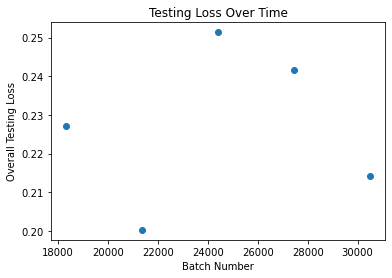

In [14]:
weight_fnames = os.listdir('./saved_weights3_tmp/')
#weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames[11::2]:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights3_tmp/{fname}', map_location=device)
    
    # network weights load
    net = torchvision.models.resnet152(weights='IMAGENET1K_V2').to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    net.load_state_dict(checkpoint['model_state_dict'])  
    criterion = nn.BCELoss()
    
    net.eval()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            outputs = outputs.to("cpu")
            label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 10 == 0:
                print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results3_tmp/results_ResNet152_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

[Batch 1525] Size Area Under the ROC Curve: 0.8572557619064345 

[Batch 4575] Size Area Under the ROC Curve: 0.8714466361907438 

[Batch 7625] Size Area Under the ROC Curve: 0.8655078456265713 

[Batch 18300] Size Area Under the ROC Curve: 0.8639631411945157 

[Batch 10675] Size Area Under the ROC Curve: 0.8671370195484144 

[Batch 13725] Size Area Under the ROC Curve: 0.8738285085364366 

[Batch 15250] Size Area Under the ROC Curve: 0.8699303670324782 

[Batch 21350] Size Area Under the ROC Curve: 0.876193654250488 

[Batch 24400] Size Area Under the ROC Curve: 0.8731728245761052 

[Batch 27450] Size Area Under the ROC Curve: 0.8684784954060306 

[Batch 30500] Size Area Under the ROC Curve: 0.8603878236812306 



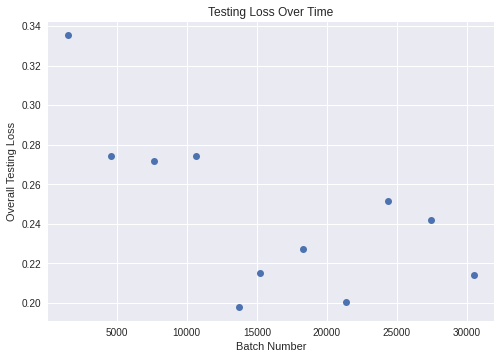

In [15]:
plt.style.use('seaborn')

# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results3_tmp/')
    
    for fname in res_fnames:
        with open(f'./saved_results3_tmp/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"]) 
            
            
            gt = res["ground_truths"]
            probs = np.array(res["probs"])

            # match formats (shouldve done this before, forgot to check)
            ground_truths = []
            for i in range(len(gt)):
                if gt[i].size() > torch.Size([1]):
                    ground_truths += gt[i].squeeze(-1).tolist()
                else:
                    ground_truths.append(gt[i].squeeze(-1).tolist())

            ground_truths = np.array(ground_truths)
            print(f"[Batch {res['num_batches']}] Size Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [16]:
best_batch_size = 21350


with open(f'./saved_results3/results_ResNet50_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

Max F2-Score is: 0.34424853064651556
Max G-Mean is: 0.8065287772568284
Max Cohen's Kappa is: 0.2412570888468809
Area Under the ROC Curve: 0.8871136357173802 



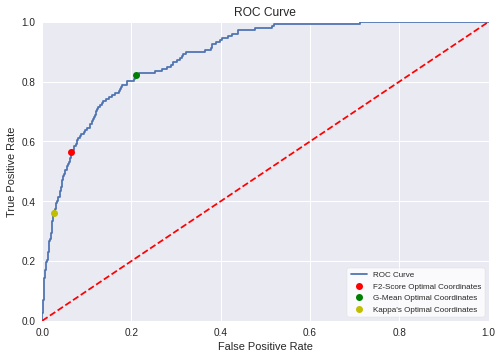


********************* USING F2-SCORE OPTIMAL THRESHOLD *************************
The confusion matrix is:
 [[7613  521]
 [  65   82]] 

Recall / Sensitivity: 0.564625850340136
Precision: 0.13598673300165837
Specificity: 0.9359478731251537
F2-Score: 0.34424853064651556
G-Mean: 0.7269527933348434
Cohen's Kappa: 0.1957086703700095
********************************************************************************


********************** USING G-MEAN OPTIMAL THRESHOLD **************************
The confusion matrix is:
 [[6428 1706]
 [  27  120]] 

Recall / Sensitivity: 0.8231292517006803
Precision: 0.06571741511500548
Specificity: 0.7902630931890828
F2-Score: 0.24855012427506212
G-Mean: 0.8065287772568284
Cohen's Kappa: 0.09180075725391579
********************************************************************************


********************** USING KAPPA OPTIMAL THRESHOLD ***************************
The confusion matrix is:
 [[7924  210]
 [  94   53]] 

Recall / Sensitivity: 0.36054421768

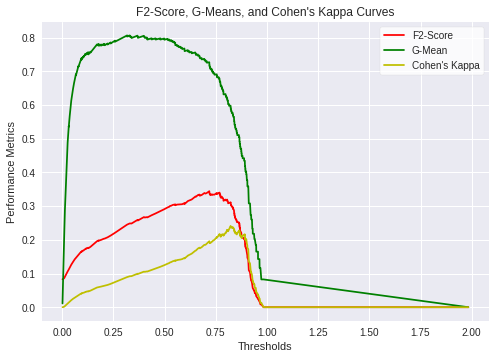

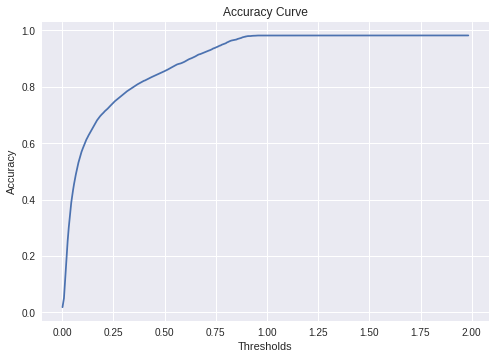

In [17]:
import warnings
warnings.filterwarnings('ignore')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()